This package implements the basic machinery for decorrelated backpropagation.

In [1]:
import numpy as np
import torch
from decorrelation import covariance, DecorrelationPatch2d, DecorrelationFC
import matplotlib.pyplot as plt

We start by showing effective decorrelation of correlated input

iteration 0; average off-diagonal covariance: 0.242866
iteration 1; average off-diagonal covariance: 0.240993
iteration 2; average off-diagonal covariance: 0.239152
iteration 3; average off-diagonal covariance: 0.237343
iteration 4; average off-diagonal covariance: 0.235565
iteration 5; average off-diagonal covariance: 0.233817
iteration 6; average off-diagonal covariance: 0.232098
iteration 7; average off-diagonal covariance: 0.230408
iteration 8; average off-diagonal covariance: 0.228746
iteration 9; average off-diagonal covariance: 0.227111
iteration 10; average off-diagonal covariance: 0.225502
iteration 11; average off-diagonal covariance: 0.223919
iteration 12; average off-diagonal covariance: 0.222362
iteration 13; average off-diagonal covariance: 0.220829
iteration 14; average off-diagonal covariance: 0.219320
iteration 15; average off-diagonal covariance: 0.217835
iteration 16; average off-diagonal covariance: 0.216373
iteration 17; average off-diagonal covariance: 0.214933
it

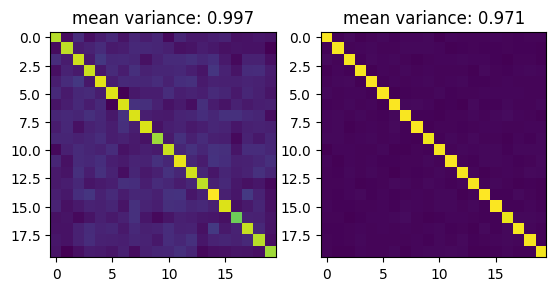

In [3]:
num_samples=1000
num_features=20

# generate correlated data
d = torch.distributions.MultivariateNormal(torch.zeros(num_features), 0.8 * torch.eye(num_features) + 0.2 * torch.ones((num_features, num_features)))
data = d.sample((num_samples,))

# create a fully connected decorrelator
model = DecorrelationFC(num_features, whiten=True) # NOTE: the whitening constraint is only realised weakly due to the off-diagonal constraints; we observe a weak tendency to unit variance

# covariance matrix before training
A1 = model.covariance(model.forward(data))

# train decorrelator
for i in range(1000):
    y = model.forward(data)
    model.update()
    model.R -= 1e-3 * model.R.grad
    print(f'iteration {i}; average off-diagonal covariance: {covariance([model])[0].numpy():3f}')

# covariance matrix after training
A2 = model.covariance(model.forward(data))

plt.subplot(1,2,1)
plt.imshow(A1)
plt.title(f'mean variance: {torch.mean(torch.diag(A1)):.3f}')
plt.subplot(1,2,2)
plt.imshow(A2)
plt.title(f'mean variance: {torch.mean(torch.diag(A2)):.3f}');


Decorrelation of correlated input represented in convolutional [N, C, H, W] form

iteration 0; average off-diagonal kernel covariance: 0.829981
iteration 1; average off-diagonal kernel covariance: 0.293782
iteration 2; average off-diagonal kernel covariance: 0.218844
iteration 3; average off-diagonal kernel covariance: 0.177485
iteration 4; average off-diagonal kernel covariance: 0.150630
iteration 5; average off-diagonal kernel covariance: 0.131593
iteration 6; average off-diagonal kernel covariance: 0.117315
iteration 7; average off-diagonal kernel covariance: 0.106174
iteration 8; average off-diagonal kernel covariance: 0.097220
iteration 9; average off-diagonal kernel covariance: 0.089857
iteration 10; average off-diagonal kernel covariance: 0.083688
iteration 11; average off-diagonal kernel covariance: 0.078442
iteration 12; average off-diagonal kernel covariance: 0.073924
iteration 13; average off-diagonal kernel covariance: 0.069990
iteration 14; average off-diagonal kernel covariance: 0.066535
iteration 15; average off-diagonal kernel covariance: 0.063474
it

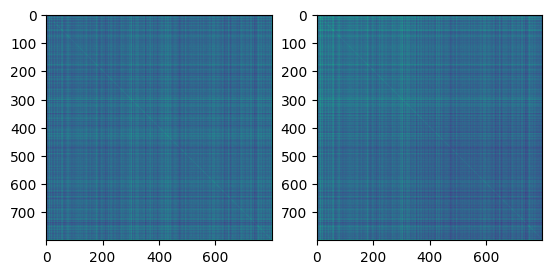

In [11]:
# generate [N, M] correlated input
num_examples=100
num_channels=2
height=20
width=20
num_features=num_channels*height*width
kernel_size=(5,5)

d = torch.distributions.MultivariateNormal(torch.zeros(num_features), 0.1 * torch.eye(num_features) + 0.9 * torch.ones((num_features, num_features)))
data = d.sample((num_examples,)).reshape(num_examples,num_channels,height,width)

# create a convolutional decorrelator
model = DecorrelationPatch2d(2, kernel_size=kernel_size, whiten=True)

# correlation matrix before training
B1 = DecorrelationFC.covariance(model.forward(data).view(num_examples,-1))

# train decorrelator
for i in range(1000):
    y = model.forward(data)
    model.update()
    model.R -= 1e-2 * model.R.grad
    print(f'iteration {i}; average off-diagonal kernel covariance: {covariance([model])[0].numpy():3f}')

# correlation matrix after training
B2 = DecorrelationFC.covariance(model.forward(data).view(num_examples,-1))

plt.subplot(1,2,1)
plt.imshow(B1)
plt.subplot(1,2,2)
plt.imshow(B2)

# does patchwise not translate into full size????

In [12]:
B1

tensor([[0.8084, 0.7987, 0.8324,  ..., 0.8242, 0.8207, 0.8041],
        [0.7987, 0.9871, 0.9202,  ..., 0.9158, 0.9170, 0.8778],
        [0.8324, 0.9202, 1.0416,  ..., 0.9800, 0.9552, 0.9347],
        ...,
        [0.8242, 0.9158, 0.9800,  ..., 1.0873, 0.9866, 0.9354],
        [0.8207, 0.9170, 0.9552,  ..., 0.9866, 1.0620, 0.9261],
        [0.8041, 0.8778, 0.9347,  ..., 0.9354, 0.9261, 1.0190]])

In [13]:
B2

tensor([[0.0194, 0.0198, 0.0206,  ..., 0.0197, 0.0196, 0.0194],
        [0.0198, 0.0253, 0.0236,  ..., 0.0226, 0.0226, 0.0219],
        [0.0206, 0.0236, 0.0267,  ..., 0.0241, 0.0235, 0.0233],
        ...,
        [0.0197, 0.0226, 0.0241,  ..., 0.0257, 0.0233, 0.0225],
        [0.0196, 0.0226, 0.0235,  ..., 0.0233, 0.0251, 0.0222],
        [0.0194, 0.0219, 0.0233,  ..., 0.0225, 0.0222, 0.0248]])

In [7]:
model.R.shape

torch.Size([50, 50])

In [8]:
# MAYBE IT ALREADY WORKS? INPUT DATA SHOULD BE TRANSLATION INVARIANT? THIS IS DEFINITELY NOT THE CASE IN GENERAL... NEEDS MORE THOUGHT